Epoch 50, Loss: 507.7969
Epoch 100, Loss: 1168.1630
Epoch 150, Loss: 1811.2361
Epoch 200, Loss: 2436.8552


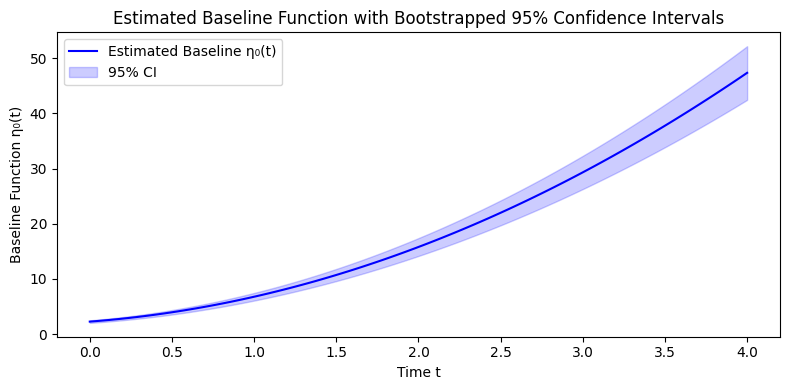

   Time (t)  Estimate η₀(t)  Lower 95% CI  Upper 95% CI
0       0.0            2.25          2.02          2.48
1       1.0            6.77          6.07          7.46
2       2.0           15.79         14.16         17.40
3       3.0           29.32         26.29         32.32
4       4.0           47.37         42.47         52.20


In [2]:
#Imports
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Dummy Functions for the Baseline Spline
# 
#two helper functions:
#1. compute_spline_basis(t)`: Returns a simple polynomial basis (1, t, t^2).
#2. numeric_integration_of_baseline(model_baseline, cend)`: 
#Uses the trapezoidal rule to approximate the integral of exp(η₀(t)) from 0 to cend.

# %%
def compute_spline_basis(t):
    """
    For demonstration, use a simple polynomial basis: [1, t, t^2].
    t: torch.Tensor of shape [n]
    Returns: torch.Tensor of shape [n, 3]
    """
    t = t.unsqueeze(-1)  #should be shape [n, 1]
    basis = torch.cat([torch.ones_like(t), t, t**2], dim=-1)
    return basis

def numeric_integration_of_baseline(model_baseline, cend, num_points=100):
    """
    Approximate the integral of exp(η₀(t)) from t=0 to cend using the trapezoidal rule.
    """
    t_grid = torch.linspace(0, cend, num_points)
    with torch.no_grad():
        eta_vals = model_baseline(t_grid)
        exp_eta = torch.exp(eta_vals)
    integral = torch.trapz(exp_eta, t_grid)
    return integral

### Model Definitions
# 
#We use/are inspired by the key classes for the FastKAN network and the BaselineSpline: 
# 
#RadialBasisEdge: A univariate edge using Gaussian radial basis functions.
#KANLayer: A layer that sums over RBF edges.
#FastKAN: A 2-layer network that maps from input dimension to a scalar output.
#BaselineSpline: A simple spline (using our polynomial basis) for η₀(t).

# %%
class RadialBasisEdge(nn.Module):
    """
    A single univariate 'edge' with multiple Gaussian RBFs.
    Computes: sum_m alpha_m * exp( -((x - center_m)^2 / sigma_m^2) )
    """
    def __init__(self, num_rbfs=4):
        super().__init__()
        self.centers = nn.Parameter(torch.randn(num_rbfs))
        self.log_sigmas = nn.Parameter(torch.zeros(num_rbfs))
        self.alphas = nn.Parameter(torch.zeros(num_rbfs))

    def forward(self, x):
        # x shape: [batch_size]
        xs = x.unsqueeze(-1)  # [batch_size, 1]
        r2 = (xs - self.centers)**2 / torch.exp(2 * self.log_sigmas)  # [batch_size, num_rbfs]
        phi = torch.exp(-r2) * self.alphas  # element-wise multiplication
        return torch.sum(phi, dim=-1)       # sum over the RBFs

class KANLayer(nn.Module):
    """
    A KAN layer that maps from in_dim to out_dim using univariate RBF edges.
    """
    def __init__(self, in_dim, out_dim, num_rbfs=4):
        super().__init__()
        self.edges = nn.ModuleList([RadialBasisEdge(num_rbfs) for _ in range(out_dim * in_dim)])
        self.in_dim = in_dim
        self.out_dim = out_dim

    def forward(self, z_in):
        # z_in: [batch_size, in_dim]
        batch_size = z_in.shape[0]
        z_out = torch.zeros(batch_size, self.out_dim, device=z_in.device)
        idx = 0
        for u in range(self.out_dim):
            sum_u = 0
            for v in range(self.in_dim):
                sum_u += self.edges[idx](z_in[:, v])
                idx += 1
            z_out[:, u] = sum_u
        return z_out

class FastKAN(nn.Module):
    """
    A 2-layer FastKAN network from dimension d_x -> 1 using radial basis edges.
    """
    def __init__(self, d_x, hidden_dim, num_rbfs=4):
        super().__init__()
        self.layer1 = KANLayer(d_x, hidden_dim, num_rbfs)
        self.layer2 = KANLayer(hidden_dim, 1, num_rbfs)

    def forward(self, x):
        z = self.layer1(x)
        z = self.layer2(z)
        return z.squeeze(-1)

class BaselineSpline(nn.Module):
    """
    B-spline representation of the baseline function η₀(t).
    Uses a simple polynomial basis (for demonstration).
    """
    def __init__(self, n_spline_terms):
        super().__init__()
        self.coefs = nn.Parameter(torch.zeros(n_spline_terms))
    
    def forward(self, t):
        # t: torch.Tensor; 
        #this returns a scalar for each t by computing the dot product with spline coefficients.
        basis = compute_spline_basis(t)  #should be shape: [n, n_spline_terms]
        return basis @ self.coefs

### Log-Likelihood Function
# 
# The log-likelihood for a subject (with recurrent events) is given by:
#
# Latex code:  
# \[
# \log L_i = \sum_{j=1}^{n_i} [\eta_0(t_{ij}) + f(x_i)] - \exp(f(x_i)) \int_0^{c_i} e^{\eta_0(t)} dt.
# \]
# 
# The function below computes the total log-likelihood for a list of subjects.

# %%
def compute_loglik(model_baseline, model_fastkan, data):
    """
    data: list of tuples (tvals, cend, covar)
          - tvals: tensor of event times for a subject
          - cend: censoring time (scalar tensor)
          - covar: tensor of covariates (here, a single scalar)
    """
    loglike = 0.
    for tvals, cend, covar in data:
        bvals = model_baseline(tvals)            #[n_events]
        fval = model_fastkan(covar.unsqueeze(0))   #shape: [1]
        sum_events = torch.sum(bvals) + len(tvals) * fval
        integral_val = numeric_integration_of_baseline(model_baseline, cend)
        sum_int = torch.exp(fval) * integral_val
        loglike += (sum_events - sum_int)
    return loglike

### Synthetic Data Generation
# 
# We simulate data for a number of subjects. For each subject, we generate:
# 
# - A censoring time between 2 and 4 (time units).
# - A random number of events (between 1 and 5) with event times uniformly distributed in [0, cend].
# - A single covariate drawn from a standard normal distribution.

# %%
def generate_synthetic_data(num_subjects=50):
    data = []
    for i in range(num_subjects):
        cend = torch.tensor(np.random.uniform(2.0, 4.0))
        num_events = np.random.randint(1, 6)
        tvals = torch.sort(torch.rand(num_events) * cend)[0]
        covar = torch.randn(1)  # single covariate
        data.append((tvals, cend, covar))
    return data

# Generate synthetic data
synthetic_data = generate_synthetic_data(num_subjects=50)

### Training the Model
# 
#We initialize the BaselineSpline and FastKAN models, 
#combine their parameters in an Adam optimizer, 
#and run a training loop over several epochs to maximize the log-likelihood.

# %%
#model parameters
d_x = 1
hidden_dim = 5
num_rbfs = 4
n_spline_terms = 3  # matching our polynomial basis dimensions

#initialize models
model_baseline = BaselineSpline(n_spline_terms)
model_fastkan = FastKAN(d_x, hidden_dim, num_rbfs)

#set up optimizer
optimizer = optim.Adam(list(model_baseline.parameters()) + list(model_fastkan.parameters()), lr=0.01)

#training loop
num_epochs = 200
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loglike = compute_loglik(model_baseline, model_fastkan, synthetic_data)
    loss = -loglike  #maximize the log-likelihood, so minimize its negative
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

### Bootstrap for Baseline Function Confidence Intervals
# 
# We perform bootstrap resampling at the subject level. 
#In each bootstrap iteration, we resample the subjects, 
#take one gradient step on the bootstrap sample, 
#and record the baseline function estimates on a grid of time points.

# %%
def bootstrap_baseline_estimates(model_baseline, model_fastkan, data, num_bootstrap=50, grid_times=None):
    if grid_times is None:
        grid_times = torch.linspace(0, 4, 100)
    estimates = []
    num_subjects = len(data)
    for b in range(num_bootstrap):
        #resample subjects with replacement
        indices = np.random.choice(num_subjects, num_subjects, replace=True)
        bootstrap_data = [data[i] for i in indices]
        
        #just for demonstration, let's perform one gradient step on the bootstrap sample
        #can adjust as needed
        optimizer.zero_grad()
        loglike_bs = compute_loglik(model_baseline, model_fastkan, bootstrap_data)
        loss_bs = -loglike_bs
        loss_bs.backward()
        optimizer.step()
        
        #record baseline estimates on the grid
        with torch.no_grad():
            eta_est = model_baseline(grid_times)
        estimates.append(eta_est.cpu().numpy())
    
    return grid_times.cpu().numpy(), np.array(estimates)

#now run bootstrap
grid_times, bs_estimates = bootstrap_baseline_estimates(model_baseline, model_fastkan, synthetic_data, num_bootstrap=50)

### Visualization of Baseline Function with Bootstrapped Confidence Intervals
# 
# We compute the mean and the 2.5th and 97.5th percentiles at each grid time to form the 95% confidence interval, and then plot the estimated baseline function along with the confidence bands.

#compute mean and 95% confidence intervals
mean_est = np.mean(bs_estimates, axis=0)
lower_ci = np.percentile(bs_estimates, 2.5, axis=0)
upper_ci = np.percentile(bs_estimates, 97.5, axis=0)

plt.figure(figsize=(8, 4))
plt.plot(grid_times, mean_est, label="Estimated Baseline η₀(t)", color="blue")
plt.fill_between(grid_times, lower_ci, upper_ci, color="blue", alpha=0.2, label="95% CI")
plt.xlabel("Time t")
plt.ylabel("Baseline Function η₀(t)")
plt.title("Estimated Baseline Function with Bootstrapped 95% Confidence Intervals")
plt.legend()
plt.tight_layout()
plt.show()

### Final Summary Table of Baseline Estimates
# 
#Summarize the baseline estimates at selected time points for summary (can be adjusted)
selected_times = np.array([0.0, 1.0, 2.0, 3.0, 4.0])
selected_est = np.interp(selected_times, grid_times, mean_est)
selected_lower = np.interp(selected_times, grid_times, lower_ci)
selected_upper = np.interp(selected_times, grid_times, upper_ci)

summary_df = pd.DataFrame({
    "Time (t)": selected_times,
    "Estimate η₀(t)": np.round(selected_est, 2),
    "Lower 95% CI": np.round(selected_lower, 2),
    "Upper 95% CI": np.round(selected_upper, 2)
})
print(summary_df)
